# Travelers | NESS 2022 Hackathon Competition
##   Property Policy Retention

## Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
# Reading datasets
train = pd.read_csv('/cis/home/achatto1/new_project/trv-ness-hackathon-2022/train.csv')


In [ ]:
train.info()
# house.color, credit, coverage.type, dwelling.type, sales.channel, ni.gender are categorical variables
# id is not useful for this analysis.
# cancel is our target variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 18 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   id                 1048575 non-null  int64  
 1   cancel             1048575 non-null  int64  
 2   year               1048575 non-null  int64  
 3   zip.code           1047624 non-null  float64
 4   house.color        1047630 non-null  object 
 5   ni.age             1047573 non-null  float64
 6   len.at.res         1047608 non-null  float64
 7   credit             1047668 non-null  object 
 8   coverage.type      1047595 non-null  object 
 9   dwelling.type      1047582 non-null  object 
 10  premium            1047618 non-null  float64
 11  sales.channel      1047550 non-null  object 
 12  ni.gender          1047615 non-null  object 
 13  ni.marital.status  1047581 non-null  float64
 14  n.adults           1047644 non-null  float64
 15  n.children         1047637 non-n

In [ ]:
# Drop Rows corresponding Null Values
train.isnull().sum()
train.dropna(inplace=True)
train.isnull().sum()

id                   0
cancel               0
year                 0
zip.code             0
house.color          0
ni.age               0
len.at.res           0
credit               0
coverage.type        0
dwelling.type        0
premium              0
sales.channel        0
ni.gender            0
ni.marital.status    0
n.adults             0
n.children           0
tenure               0
claim.ind            0
dtype: int64

In [ ]:
# Drop ID column
train.drop(['id'],axis=1,inplace=True)
train.head()

,cancel,year,zip.code,house.color,ni.age,len.at.res,credit,coverage.type,dwelling.type,premium,sales.channel,ni.gender,ni.marital.status,n.adults,n.children,tenure,claim.ind
0,0,2013,98004.0,blue,37.0,18.000000,high,C,Tenant,950.507336,Broker,F,0.0,2.0,0.0,15.0,0.0
1,0,2013,85017.0,white,40.0,17.000000,medium,A,Condo,909.346046,Broker,F,1.0,5.0,0.0,15.0,0.0
2,0,2013,80021.0,white,45.0,14.000000,high,A,House,897.084502,Phone,M,0.0,1.0,0.0,14.0,0.0
3,0,2013,85002.0,red,45.0,24.366136,high,A,House,979.039007,Phone,M,0.0,5.0,0.0,22.0,1.0
4,0,2013,50001.0,yellow,36.0,16.000000,high,C,House,932.379027,Broker,M,1.0,2.0,4.0,4.0,0.0


#### Outliers in ni.age

/cis/home/achatto1/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ni.age', ylabel='Density'>

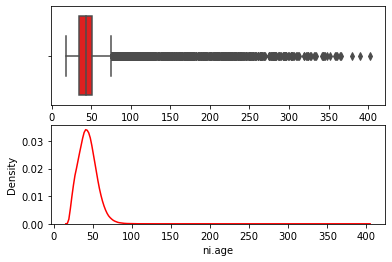

In [ ]:
# Checking for outliers in ni.age.


fig, axes = plt.subplots(2, 1)

sns.boxplot(train['ni.age'], ax=axes[0], color='red')
sns.kdeplot(train['ni.age'], ax=axes[1], color='red')



In [ ]:

# In test set there are 2 age values greater than 100, with highest 286.61
# In training set there are 858 age values greater than 100, with highest 402.4

# There might be cases, where house insurance is named under elderly people, so as to claim benefits of senior citizen
# https://getjerry.com/questions/does-my-age-affect-home-insurance
sum(train['ni.age'] >  100)
sum(train['ni.age'] >  100)

# Excluding age values greater than 100.
train = train[train['ni.age'] <= 100]



#### Removing -1 observation

In [ ]:
train = train[train['cancel']!=-1]

## Feature Engineering

#### Encoding Zip Code

In [ ]:
# Encoding Zip Code
zip_code = round(train['zip.code'],-3)
zone = []

print(zip_code.unique())
for i in zip_code:
    if i==85000.0:
        zone.append(2)
    elif i==80000.0:
        zone.append(3)
    elif i==98000.0:
        zone.append(1)
    elif i==50000.0:
        zone.append(6)
    elif i==15000.0:
        zone.append(5)
    else:
        zone.append(4)
    
    
train['zone'] = zone
#train.drop(['zip.code'],axis=1,inplace=True)

[98000. 85000. 80000. 50000. 15000. 20000.]


#### Computing Family size

In [ ]:
#### Computing family size.
n_total = train['n.adults']+train['n.children']

train['n.family'] = n_total

#train.drop(['n.children','n.adults'],axis=1,inplace=True)





#### Number of Year remaining

In [ ]:
total_years_passed_by =2022-train['year']
years_remaining=train['tenure']-total_years_passed_by
train['years_remaining']=years_remaining

In [ ]:
#### Binning years remaining.
bin_years_remaining = []
for i in years_remaining:
    if i <= 0.0:
        bin_years_remaining.append('Completed')
    elif ((i > 0.0) and (i <= 10.0)):
        bin_years_remaining.append('0-10 Years')
    elif i > 10.0:
        bin_years_remaining.append('> 10 Years')

train['bin_years_remaining']=bin_years_remaining

## Predictors group by target variable

### In this section we will be checking how following categorical variables are affecting our target variable cancel
#### 1) house.color
#### 2) credit
#### 3) coverage.type
#### 4) dwelling.type
#### 5) sales.channel
#### 6) ni.gender
#### 7) ni.marital.status
#### 8) claim_ind
#### 9) zone

#### 1)  house.color

<AxesSubplot:title={'center':'house.color vs cancel'}, xlabel='house.color', ylabel='normalized_count'>

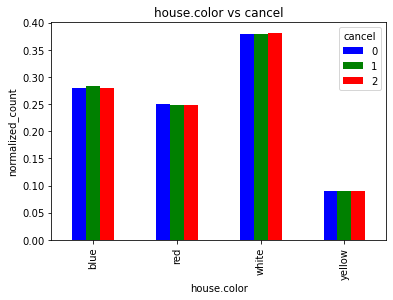

In [ ]:
pd.crosstab(index=train['house.color'], columns=train['cancel'],normalize='columns').plot(kind='bar',color={'blue','green','red'},title = 'house.color vs cancel',ylabel='normalized_count')




#### 2) credit


<AxesSubplot:title={'center':'credit vs cancel'}, xlabel='credit', ylabel='normalized_count'>

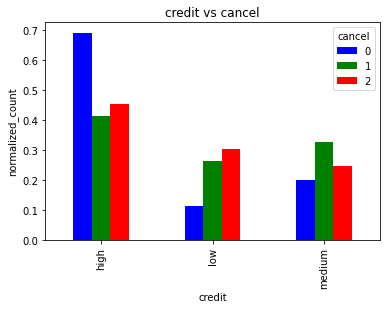

In [ ]:
pd.crosstab(index=train['credit'], columns=train['cancel'],normalize="columns").plot(kind='bar',color={'blue','green','red'},title = 'credit vs cancel',ylabel='normalized_count')




#### 3) coverage.type

<AxesSubplot:title={'center':'coverage.type vs cancel'}, xlabel='coverage.type', ylabel='normalized_count'>

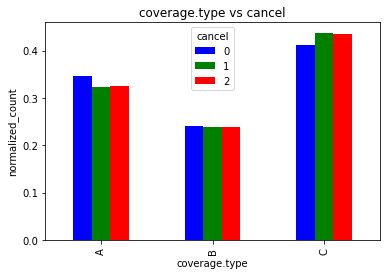

In [ ]:
pd.crosstab(index=train['coverage.type'], columns=train['cancel'], normalize="columns").plot(kind='bar',color={'blue','green','red'},title = 'coverage.type vs cancel',ylabel='normalized_count')


#### dwelling.type

<AxesSubplot:title={'center':'dwelling.type vs cancel'}, xlabel='dwelling.type', ylabel='normalized_count'>

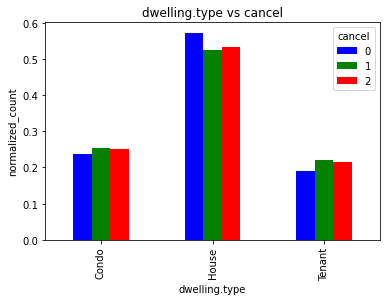

In [ ]:
pd.crosstab(index=train['dwelling.type'], columns=train['cancel'], normalize="columns").plot(kind='bar',color={'blue','green','red'},title = 'dwelling.type vs cancel',ylabel='normalized_count')


#### sales.channel

<AxesSubplot:title={'center':'sales.channel vs cancel'}, xlabel='sales.channel', ylabel='normalized_count'>

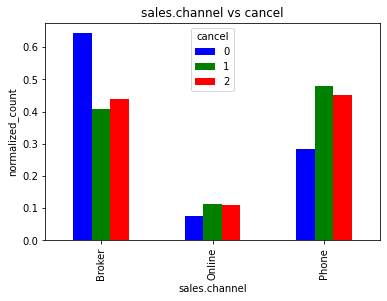

In [ ]:
pd.crosstab(index=train['sales.channel'], columns=train['cancel'], normalize="columns").plot(kind='bar',color={'blue','green','red'},title = 'sales.channel vs cancel',ylabel='normalized_count')

#### ni.gender

<AxesSubplot:title={'center':'ni.gender vs cancel'}, xlabel='ni.gender', ylabel='normalized_count'>

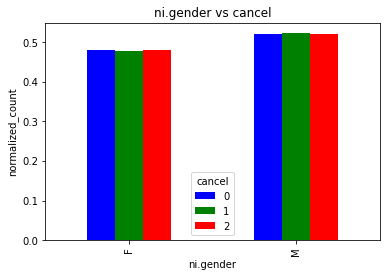

In [ ]:
pd.crosstab(index=train['ni.gender'], columns=train['cancel'], normalize="columns").plot(kind='bar',color={'blue','green','red'},title = 'ni.gender vs cancel',ylabel='normalized_count')

#### ni.marital status

<AxesSubplot:title={'center':'ni.marital status vs cancel'}, xlabel='ni.marital.status', ylabel='normalized_count'>

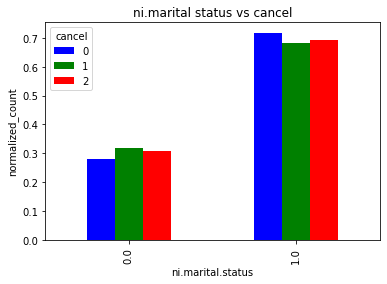

In [ ]:
pd.crosstab(index=train['ni.marital.status'], columns=train['cancel'], normalize="columns").plot(kind='bar',color={'blue','green','red'},title = 'ni.marital status vs cancel',ylabel='normalized_count')


#### Claim.ind

<AxesSubplot:title={'center':'claim.ind vs cancel'}, xlabel='claim.ind', ylabel='count'>

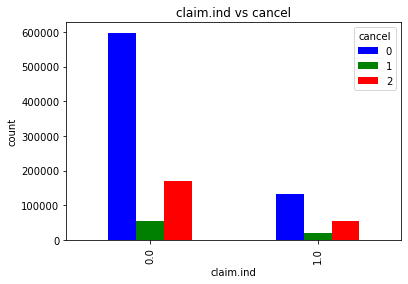

In [ ]:
pd.crosstab(index=train['claim.ind'], columns=train['cancel']).plot(kind='bar',color={'blue','green','red'},title = 'claim.ind vs cancel',ylabel='count')


#### Zone

<AxesSubplot:title={'center':'Zone vs cancel'}, xlabel='zone', ylabel='normalized_count'>

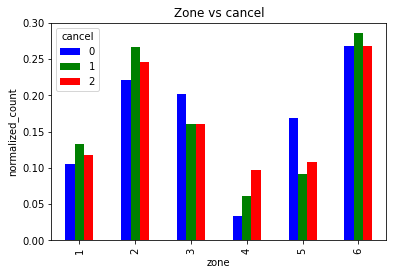

In [ ]:
pd.crosstab(index=train['zone'], columns=train['cancel'], normalize="columns").plot(kind='bar',color={'blue','green','red'},title = 'Zone vs cancel',ylabel='normalized_count')
### Zone 1,2,4,6 are least renewing states
### In Zone 1,2,6 are most likely to renew, whereas zone 4 cancelled
#### Zone 3, 5 are most likely to renew.


<AxesSubplot:title={'center':'Years Remaining vs cancel'}, xlabel='bin_years_remaining', ylabel='normalized_count'>

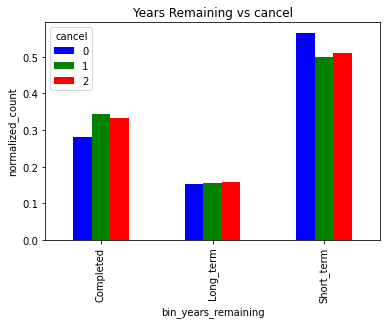

In [ ]:
pd.crosstab(index=train['bin_years_remaining'], columns=train['cancel'], normalize="columns").plot(kind='bar',color={'blue','green','red'},title = 'Years Remaining vs cancel',ylabel='normalized_count')

<AxesSubplot:title={'center':'n.Family vs cancel'}, xlabel='n.family', ylabel='normalized_count'>

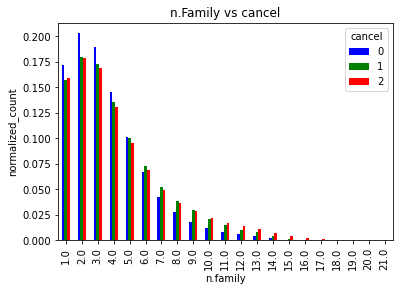

In [ ]:

# n.family, premium,len.at.res
pd.crosstab(index=train['n.family'], columns=train['cancel'], normalize="columns").plot(kind='bar',color={'blue','green','red'},title = 'n.Family vs cancel',ylabel='normalized_count')


In [ ]:
train.to_csv('/cis/home/achatto1/new_project/trv-ness-hackathon-2022/visualization.csv')

## One Hot Encoding

In [ ]:

train.head()
train = pd.get_dummies(train,drop_first=True)

## Dropping redundant columns

In [ ]:
#train_encode.head()
train_encode = train
train_encode.drop(['zip.code','year','tenure','n.adults','n.children','years_remaining'],axis=1,inplace=True)
train_encode.head()




,cancel,ni.age,len.at.res,premium,ni.marital.status,claim.ind,zone,n.family,house.color_red,house.color_white,...,credit_medium,coverage.type_B,coverage.type_C,dwelling.type_House,dwelling.type_Tenant,sales.channel_Online,sales.channel_Phone,ni.gender_M,bin_years_remaining_> 10 Years,bin_years_remaining_Completed
0,0,37.0,18.000000,950.507336,0.0,0.0,1,2.0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,0,40.0,17.000000,909.346046,1.0,0.0,2,5.0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,0,45.0,14.000000,897.084502,0.0,0.0,3,1.0,0,1,...,0,0,0,1,0,0,1,1,0,0
3,0,45.0,24.366136,979.039007,0.0,1.0,2,5.0,1,0,...,0,0,0,1,0,0,1,1,1,0
4,0,36.0,16.000000,932.379027,1.0,0.0,6,6.0,0,0,...,0,0,1,1,0,0,0,1,0,1


In [ ]:
column = 'premium'
train_encode[column] = (train_encode[column] - train_encode[column].mean()) / train_encode[column].std()  

column = 'len.at.res'
train_encode[column] = (train_encode[column] - train_encode[column].mean()) / train_encode[column].std()  
  

column = 'ni.age'
train_encode[column] = (train_encode[column] - train_encode[column].mean()) / train_encode[column].std()  
 

In [ ]:
#train_encode.drop(['id'],axis=1,inplace=True)
train1 = train_encode
train1

,cancel,ni.age,len.at.res,premium,ni.marital.status,claim.ind,zone,n.family,house.color_red,house.color_white,...,credit_medium,coverage.type_B,coverage.type_C,dwelling.type_House,dwelling.type_Tenant,sales.channel_Online,sales.channel_Phone,ni.gender_M,bin_years_remaining_> 10 Years,bin_years_remaining_Completed
0,0,-0.551517,0.609693,0.651401,0.0,0.0,1,2.0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,0,-0.295517,0.390708,0.121659,1.0,0.0,2,5.0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,0,0.131150,-0.266246,-0.036146,0.0,0.0,3,1.0,0,1,...,0,0,0,1,0,0,1,1,0,0
3,0,0.131150,2.003781,1.018602,0.0,1.0,2,5.0,1,0,...,0,0,0,1,0,0,1,1,1,0
4,0,-0.636850,0.171723,0.418091,1.0,0.0,6,6.0,0,0,...,0,0,1,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,0,2.605817,1.047663,0.347033,0.0,0.0,6,3.0,0,1,...,0,0,0,1,0,1,0,0,0,0
1048571,0,0.045817,-0.266246,0.883565,0.0,0.0,5,4.0,0,1,...,0,0,0,0,0,0,0,1,0,0
1048572,0,1.667150,0.609693,-0.790807,1.0,0.0,3,5.0,0,0,...,0,0,0,1,0,0,0,0,0,0
1048573,0,-1.831517,-0.923201,1.626353,1.0,1.0,5,2.0,0,0,...,0,0,1,1,0,1,0,1,0,1


## Test data prepreparation

In [ ]:
#reading test data
test = pd.read_csv('/cis/home/achatto1/new_project/trv-ness-hackathon-2022/test.csv')

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2412 entries, 0 to 2411
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2412 non-null   int64  
 1   tenure             2410 non-null   float64
 2   claim.ind          2410 non-null   float64
 3   n.adults           2408 non-null   float64
 4   n.children         2412 non-null   int64  
 5   ni.gender          2411 non-null   object 
 6   ni.marital.status  2410 non-null   float64
 7   premium            2411 non-null   float64
 8   sales.channel      2407 non-null   object 
 9   coverage.type      2410 non-null   object 
 10  dwelling.type      2411 non-null   object 
 11  len.at.res         2409 non-null   float64
 12  credit             2410 non-null   object 
 13  house.color        2412 non-null   object 
 14  ni.age             2409 non-null   float64
 15  year               2412 non-null   int64  
 16  zip.code           2409 

In [ ]:
# Missing values
test.isna().sum()

test.head()

,id,tenure,claim.ind,n.adults,n.children,ni.gender,ni.marital.status,premium,sales.channel,coverage.type,dwelling.type,len.at.res,credit,house.color,ni.age,year,zip.code
0,7583,5.0,0.0,1.0,3,F,1.0,913.623201,Broker,C,Tenant,18.0,medium,blue,35.0,2017,85066.0
1,7584,15.0,1.0,1.0,4,F,1.0,1018.426114,Phone,A,House,15.0,medium,white,59.0,2017,98013.0
2,7585,1.0,1.0,3.0,2,M,1.0,928.418533,Broker,B,Condo,13.0,medium,blue,27.0,2017,15049.0
3,7586,12.0,0.0,4.0,0,M,0.0,877.649917,Broker,B,Condo,19.0,high,blue,35.0,2017,15026.0
4,7587,11.0,0.0,1.0,9,F,1.0,947.281913,Broker,A,Condo,18.0,high,red,34.0,2017,15025.0


In [ ]:
#Displaying rows with null values 
#test[test.isna().any(axis=1)]

In [ ]:
#Filling null values
test = test.apply(lambda test:test.fillna(test.value_counts().index[0]))
test.head()

,id,tenure,claim.ind,n.adults,n.children,ni.gender,ni.marital.status,premium,sales.channel,coverage.type,dwelling.type,len.at.res,credit,house.color,ni.age,year,zip.code
0,7583,5.0,0.0,1.0,3,F,1.0,913.623201,Broker,C,Tenant,18.0,medium,blue,35.0,2017,85066.0
1,7584,15.0,1.0,1.0,4,F,1.0,1018.426114,Phone,A,House,15.0,medium,white,59.0,2017,98013.0
2,7585,1.0,1.0,3.0,2,M,1.0,928.418533,Broker,B,Condo,13.0,medium,blue,27.0,2017,15049.0
3,7586,12.0,0.0,4.0,0,M,0.0,877.649917,Broker,B,Condo,19.0,high,blue,35.0,2017,15026.0
4,7587,11.0,0.0,1.0,9,F,1.0,947.281913,Broker,A,Condo,18.0,high,red,34.0,2017,15025.0


In [ ]:
# Test preprocessing start

# Drop ID column
test.drop(['id'],axis=1,inplace=True)


#Zipcode to zones
zip_code = round(test['zip.code'],-3)
zone = []

print(zip_code.unique())
for i in zip_code:
    if i==85000.0:
        zone.append(2)
    elif i==80000.0:
        zone.append(3)
    elif i==98000.0:
        zone.append(1)
    elif i==50000.0:
        zone.append(6)
    elif i==15000.0:
        zone.append(5)
    else:
        zone.append(4)
    
    
test['zone'] = zone

#Family member
n_total = test['n.adults']+test['n.children']

test['n.family'] = n_total


#Years Remaining

total_years_passed_by =2022-test['year']
years_remaining=test['tenure']-total_years_passed_by
test['years_remaining']=years_remaining


#### Binning years remaining.
bin_years_remaining = []
for i in years_remaining:
    if i <= 0.0:
        bin_years_remaining.append('Completed')
    elif ((i > 0.0) and (i <= 10.0)):
        bin_years_remaining.append('Short_term')
    elif i > 10.0:
        bin_years_remaining.append('Long_term')

test['bin_years_remaining']=bin_years_remaining


# label encoding


test_encode = pd.get_dummies(test,drop_first=True)


#train_encode.head()
test_encode.drop(['zip.code','year','tenure','n.adults','n.children','years_remaining'],axis=1,inplace=True)
test_encode.head()


# Normalize
column = 'premium'
test_encode[column] = (test_encode[column] - test_encode[column].mean()) / test_encode[column].std()  

column = 'len.at.res'
test_encode[column] = (test_encode[column] - test_encode[column].mean()) / test_encode[column].std()  


column = 'ni.age'
test_encode[column] = (test_encode[column] - test_encode[column].mean()) / test_encode[column].std()




[85000. 98000. 15000. 50000. 80000. 20000.]


## Train Validation split

In [ ]:
from sklearn import preprocessing
train_encode = train1

x0 = train_encode[train_encode['cancel']==0]
x0 = x0
x1 = train_encode[train_encode['cancel']==1]
x1 = x1/1.5

x2 = train_encode[train_encode['cancel']==2]
x2 = x2*1.5


x0['cancel'] = np.repeat(0, len(x0))
x1['cancel'] = np.repeat(1, len(x1))
x2['cancel'] = np.repeat(2, len(x2))

train_encode = pd.concat([x0, x1,x2])



y_train = train_encode['cancel']
x_train = train_encode.drop(['cancel'],axis=1)





X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

x2['cancel']

<ipython-input-77-eece346e8d1d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x0['cancel'] = np.repeat(0, len(x0))


18         2
44         2
46         2
48         2
59         2
          ..
1048535    2
1048536    2
1048551    2
1048554    2
1048556    2
Name: cancel, Length: 225659, dtype: int64

(array([182415.,      0.,      0.,      0.,      0.,  18633.,      0.,
             0.,      0.,  56430.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

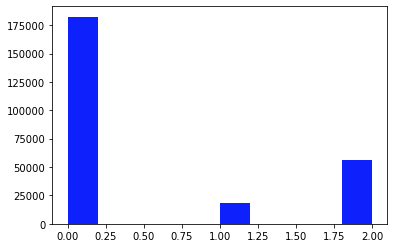

In [ ]:
hist(Y_val.values)

In [ ]:
#Re-ordering columns
test_encode = test_encode[X_train.columns]
test_encode.head()

,ni.age,len.at.res,premium,ni.marital.status,claim.ind,zone,n.family,house.color_red,house.color_white,house.color_yellow,...,credit_medium,coverage.type_B,coverage.type_C,dwelling.type_House,dwelling.type_Tenant,sales.channel_Online,sales.channel_Phone,ni.gender_M,bin_years_remaining_Long_term,bin_years_remaining_Short_term
0,-0.656215,0.629868,0.189885,1.0,0.0,2,4.0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
1,1.266434,-0.035890,1.520010,1.0,1.0,1,5.0,0,1,0,...,1,0,0,1,0,0,1,0,0,1
2,-1.297098,-0.479729,0.377662,1.0,1.0,5,5.0,0,0,0,...,1,1,0,0,0,0,0,1,0,0
3,-0.656215,0.851787,-0.266677,0.0,0.0,5,4.0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
4,-0.736325,0.629868,0.617070,1.0,0.0,5,10.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


## Unbalanced Data

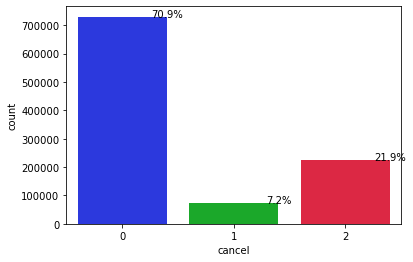

<Figure size 432x288 with 0 Axes>

In [ ]:
colors = ["#0E20FB", "#03C017", "#FA0A2F"]
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
total = float(len(train))
ax = sns.countplot(x='cancel',data=train_encode,palette=customPalette)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()
plt.show()
plt.savefig('count_plot')

In [ ]:
colors = ["#0E20FB", "#03C017", "#FA0A2F"]
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
total = float(len(test))
ax = sns.countplot(x='cancel',data=test_encode,palette=customPalette)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()
plt.show()
plt.savefig('count_plot')

NameError: name 'test' is not defined

## SMOTE (OverSampling)

In [ ]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_sample(X_train, Y_train)




In [ ]:
columns = X_train.columns

os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['cancel'])

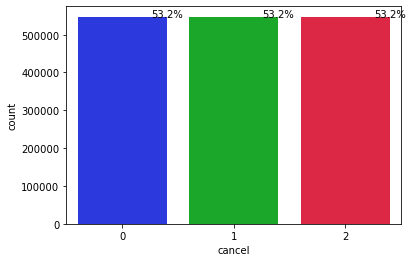

<Figure size 432x288 with 0 Axes>

In [ ]:
# Graph

## Undersampling

## Metric definitions

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
def accuracy_params(y_true,y_pred):
    print("Accuracy of the model is:",accuracy_score(y_true, y_pred))
    target_names = ['class 0', 'class 1', 'class 2']
    print(classification_report(y_true, y_pred, target_names=target_names))
    cm = confusion_matrix(Y_val, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    
    

## Logistic Regression

In [ ]:
from sklearn.linear_model  import LogisticRegression
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

###  lg1 LR without any parameters

/cis/home/achatto1/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of the model is: 0.6278764797815581
              precision    recall  f1-score   support

     class 0       0.68      0.68      0.68     18568
     class 1       0.48      0.43      0.46     18395
     class 2       0.70      0.77      0.73     18704

    accuracy                           0.63     55667
   macro avg       0.62      0.63      0.62     55667
weighted avg       0.62      0.63      0.62     55667



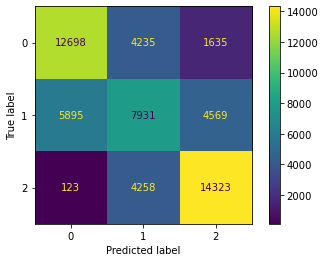

In [ ]:
# define model
lg1 = LogisticRegression(random_state=13, class_weight=None)
# fit it
lg1.fit(X_train,Y_train)
# test
y_pred1 = lg1.predict(X_val)
y_prob1 = lg1.predict_proba(X_val)
accuracy_params(Y_val,y_pred1)

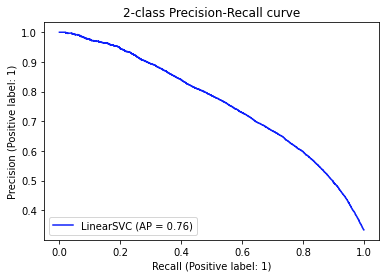

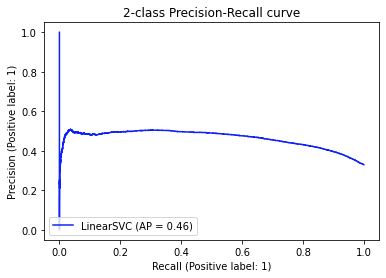

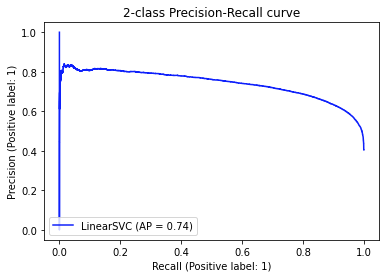

In [ ]:
probability_thresholds = np.linspace(0, 1, num=100)

real0 = np.where(Y_val==0,1,0)
real1 = np.where(Y_val==1,1,0)
real2 = np.where(Y_val==2,1,0)


pred0 = y_prob1[:,0]
pred1 = y_prob1[:,1]
pred2 = y_prob1[:,2]

from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(real0, pred0, name="LinearSVC")
_ = display.ax_.set_title("2-class Precision-Recall curve")

display = PrecisionRecallDisplay.from_predictions(real1, pred1, name="LinearSVC")
_ = display.ax_.set_title("2-class Precision-Recall curve")

display = PrecisionRecallDisplay.from_predictions(real2, pred2, name="LinearSVC")
_ = display.ax_.set_title("2-class Precision-Recall curve")


### lg2 LR with class weights

/cis/home/achatto1/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of the model is: 0.8407048369181056
              precision    recall  f1-score   support

     class 0       0.84      0.95      0.89    182415
     class 1       0.47      0.14      0.22     18633
     class 2       0.87      0.71      0.78     56430

    accuracy                           0.84    257478
   macro avg       0.73      0.60      0.63    257478
weighted avg       0.82      0.84      0.82    257478



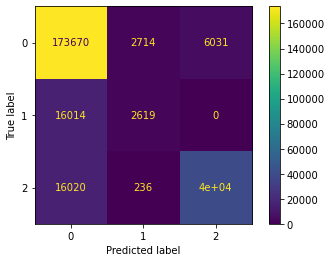

In [ ]:
w1 = {0:1/100.0,1:1/7.2,2:1/20}
lg2 = LogisticRegression(max_iter=100)
# fit it
lg2.fit(X_train,Y_train)
# test
y_pred = lg2.predict(X_val)
y_prob = lg2.predict_proba(X_val)
accuracy_params(Y_val,y_pred)

In [ ]:
probability_thresholds = np.linspace(0, 1, num=100)

real0 = np.where(Y_val==0,1,0)
real1 = np.where(Y_val==1,1,0)
real2 = np.where(Y_val==2,1,0)


pred0 = y_prob[:,0]
pred1 = y_prob[:,1]
pred2 = y_prob[:,2]


from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(real0, pred0, name="Class-0")
_ = display.ax_.set_title("0-class Precision-Recall curve")

display = PrecisionRecallDisplay.from_predictions(real1, pred1, name="Class-1")
_ = display.ax_.set_title("1-class Precision-Recall curve")

display = PrecisionRecallDisplay.from_predictions(real2, pred2, name="Class-2")
_ = display.ax_.set_title("2-class Precision-Recall curve")


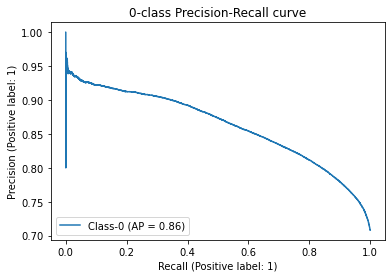

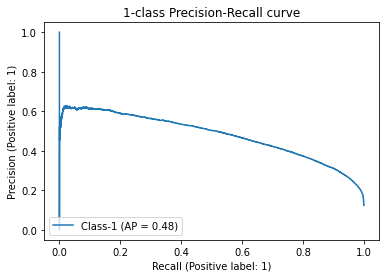

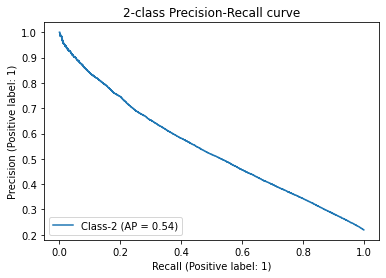

## Decision Tree

Accuracy of the model is: 0.7201430801854916
              precision    recall  f1-score   support

     class 0       0.73      0.96      0.83    182415
     class 1       0.19      0.00      0.00     18633
     class 2       0.58      0.18      0.27     56430

    accuracy                           0.72    257478
   macro avg       0.50      0.38      0.37    257478
weighted avg       0.66      0.72      0.65    257478



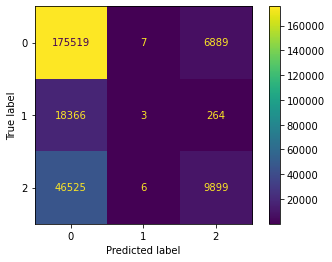

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=9)
clf = clf.fit(X_train,Y_train)
pred2 = clf.predict(X_val)
prob2 = clf.predict_proba(X_val)
accuracy_params(Y_val,pred2)


In [ ]:
prob2

array([[7.36793963e-01, 6.47915237e-02, 1.98414513e-01],
       [5.98116891e-01, 9.95521874e-02, 3.02330922e-01],
       [7.82252560e-01, 3.48122867e-02, 1.82935154e-01],
       ...,
       [9.16662270e-01, 1.31905239e-04, 8.32058249e-02],
       [5.67567568e-01, 6.75675676e-02, 3.64864865e-01],
       [5.98116891e-01, 9.95521874e-02, 3.02330922e-01]])

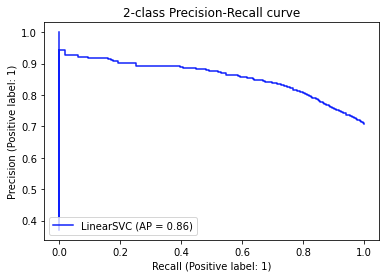

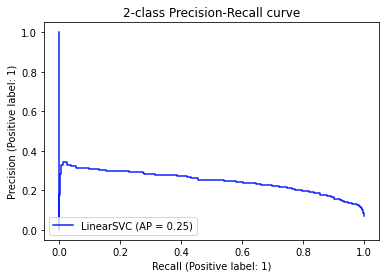

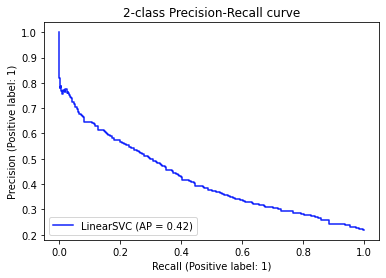

In [ ]:
probability_thresholds = np.linspace(0, 1, num=100)

real0 = np.where(Y_val==0,1,0)
real1 = np.where(Y_val==1,1,0)
real2 = np.where(Y_val==2,1,0)


pred0 = prob2[:,0]
pred1 = prob2[:,1]
pred2 = prob2[:,2]

from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(real0, pred0, name="LinearSVC")
_ = display.ax_.set_title("2-class Precision-Recall curve")

display = PrecisionRecallDisplay.from_predictions(real1, pred1, name="LinearSVC")
_ = display.ax_.set_title("2-class Precision-Recall curve")

display = PrecisionRecallDisplay.from_predictions(real2, pred2, name="LinearSVC")
_ = display.ax_.set_title("2-class Precision-Recall curve")


## XGB Boost

In [ ]:
from xgboost.sklearn import XGBClassifier
#initial model
xgb1 = XGBClassifier(num_class=3,
                                  learning_rate=0.1,
                                  num_iterations=1000,
                                  max_depth=10,
                                  feature_fraction=0.7, 
                                  scale_pos_weight=5,
                                  boosting='gbdt',
                                  metric='multiclass',
                                  eval_metric='mlogloss')

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

#allow logloss and classification error plots for each iteraetion of xgb model
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()
        
def fitXgb(sk_model, X,y,X1,y1,epochs=300):
    print('Fitting model...')
    sk_model.fit(X, y)
    print('Fitting done!')
    train = xgb.DMatrix(X, label=y)
    val = xgb.DMatrix(X, label=y)
    params = sk_model.get_xgb_params()
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    store = {}
    evallist = [(val, 'val'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist,evals_result=store,verbose_eval=100)
    #print('-- Model Report --')
    #print('XGBoost Accuracy: '+str(accuracy_score(sk_model.predict(X1),y1)))
    #print('XGBoost F1-Score (Micro): '+str(f1_score(sk_model.predict(X1),y1,average='micro')))
    #plot_compare(metrics,store,epochs)
    #features = ['nTouchpoints', 'single', 'divorced', 'married', 'unknown', 'P4',
     #  'P3', 'P2', 'P1', 'U', 'N', 'Y', 'C', 'B', 'D', 'A', 'F', 'E', 'New',
     #  'G', 'nAveSpend', 'nIncome', 'nAge']
    #f, ax = plt.subplots(figsize=(10,5))
    #plot = sns.barplot(x=features, y=sk_model.feature_importances_)
    #ax.set_title('Feature Importance')
    #plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
    #plt.show()

In [ ]:
epochs = 1
#xgb.set_config(verbosity=0)

fitXgb(xgb1,X_train,Y_train,X_val,Y_val, epochs)

Fitting model...
[13:10:30] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting", "feature_fraction", "metric", "num_iterations", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




KeyboardInterrupt: 

[0.00290257 0.00149517 0.00142013 0.27357668 0.00783759 0.0125246
 0.01793677 0.00177721 0.0026856  0.0012366  0.22015247 0.09824191
 0.00329695 0.00682756 0.05443861 0.0131347  0.04671152 0.1984928
 0.02491546 0.00244498 0.0079502 ]
Index(['ni.age', 'len.at.res', 'premium', 'ni.marital.status', 'claim.ind',
       'zone', 'n.family', 'house.color_red', 'house.color_white',
       'house.color_yellow', 'credit_low', 'credit_medium', 'coverage.type_B',
       'coverage.type_C', 'dwelling.type_House', 'dwelling.type_Tenant',
       'sales.channel_Online', 'sales.channel_Phone', 'ni.gender_M',
       'bin_years_remaining_> 10 Years', 'bin_years_remaining_Completed'],
      dtype='object')


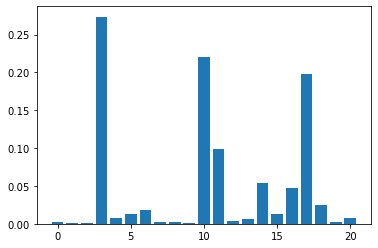

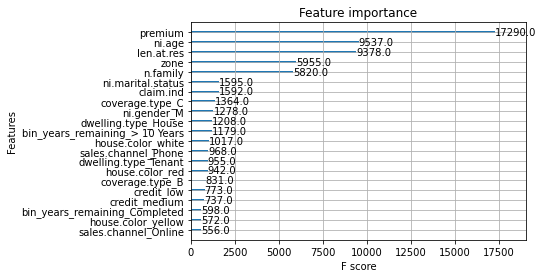

In [ ]:
from matplotlib import pyplot
from xgboost import plot_importance
print(xgb1.feature_importances_)
# plot

print(X_train.columns)
pyplot.bar(range(len(xgb1.feature_importances_)), xgb1.feature_importances_)
pyplot.show()


# plot feature importance
plot_importance(xgb1)
pyplot.show()



Accuracy of the model is: 0.7966195170072783
              precision    recall  f1-score   support

     class 0       0.80      0.95      0.87    182415
     class 1       1.00      1.00      1.00     18633
     class 2       0.59      0.24      0.34     56430

    accuracy                           0.80    257478
   macro avg       0.80      0.73      0.74    257478
weighted avg       0.77      0.80      0.76    257478



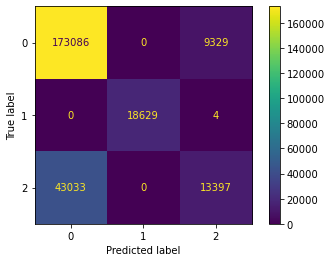

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

import scikitplot as skplt
y_pred = xgb1.predict(X_val)
y_proba = xgb1.predict_proba(X_val)
#clf.score(X_val, Y_val)





accuracy_params(Y_val,y_pred)

[1.7168610e-03 5.6503504e-04 4.0648662e-04 2.3670420e-03 4.8335944e-03
 3.8838766e-03 3.5414854e-03 3.0673269e-04 2.5126527e-04 2.5850045e-04
 6.6051453e-01 9.4347730e-02 2.6434040e-04 5.2371412e-04 5.4891646e-04
 6.1140262e-04 2.6094595e-02 1.9762307e-01 2.8511486e-04 7.0870260e-04
 3.4706175e-04]
Index(['ni.age', 'len.at.res', 'premium', 'ni.marital.status', 'claim.ind',
       'zone', 'n.family', 'house.color_red', 'house.color_white',
       'house.color_yellow', 'credit_low', 'credit_medium', 'coverage.type_B',
       'coverage.type_C', 'dwelling.type_House', 'dwelling.type_Tenant',
       'sales.channel_Online', 'sales.channel_Phone', 'ni.gender_M',
       'bin_years_remaining_Long_term', 'bin_years_remaining_Short_term'],
      dtype='object')


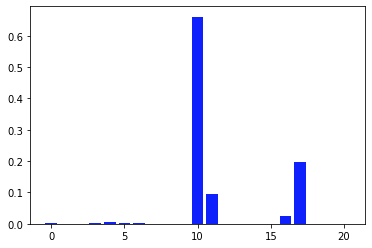

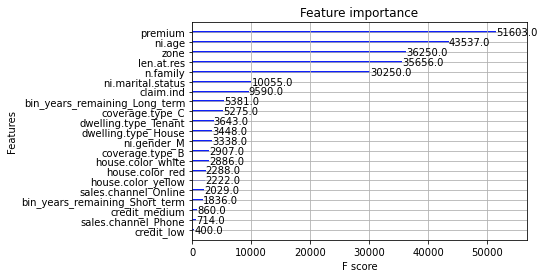

In [ ]:
from matplotlib import pyplot
from xgboost import plot_importance
print(xgb1.feature_importances_)
# plot

print(X_train.columns)
pyplot.bar(range(len(xgb1.feature_importances_)), xgb1.feature_importances_)
pyplot.show()


# plot feature importance
plot_importance(xgb1)
pyplot.show()


## Testing the model with test_encode

In [ ]:
df = pd.DataFrame()

y = xgb1.predict(test_encode)
df['predictions'] = y
df.to_csv("/cis/home/achatto1/new_project/final_result1.csv")